# Milestone 1: Dengue Investigation
This research have been done by Elena María Ruiz and Raúl Bernalte for the subject Machine Learning Techniques at UCLM.

The purpose of this research is to determine and predict Dengue spread phenomenon. To reach this objective, we are going to have a data source from the web page of Driven Data.

---

This data has the following features:

* ``city`` – City abbreviations: sj for San Juan and iq for Iquitos
* ``week_start_date`` – Date given in yyyy-mm-dd format


* ``station_max_temp_c`` – Maximum temperature
* ``station_min_temp_c`` – Minimum temperature
* ``station_avg_temp_c`` – Average temperature
* ``station_precip_mm`` – Total precipitation
* ``station_diur_temp_rng_c`` – Diurnal temperature range


* ``precipitation_amt_mm`` – Total precipitation


* ``reanalysis_sat_precip_amt_mm`` – Total precipitation
* ``reanalysis_dew_point_temp_k`` – Mean dew point temperature
* ``reanalysis_air_temp_k`` – Mean air temperature
* ``reanalysis_relative_humidity_percent`` – Mean relative humidity
* ``reanalysis_specific_humidity_g_per_kg`` – Mean specific humidity
* ``reanalysis_precip_amt_kg_per_m2`` – Total precipitation
* ``reanalysis_max_air_temp_k`` – Maximum air temperature
* ``reanalysis_min_air_temp_k`` – Minimum air temperature
* ``reanalysis_avg_temp_k`` – Average air temperature
* ``reanalysis_tdtr_k`` – Diurnal temperature range


* ``ndvi_se`` – Pixel southeast of city centroid
* ``ndvi_sw`` – Pixel southwest of city centroid
* ``ndvi_ne`` – Pixel northeast of city centroid
* ``ndvi_nw`` – Pixel northwest of city centroid

## Initialization

First of all we are going to import all the Python libraries normally used in data science.

In [1]:
# data load and manipulation
from google.colab import files
import io
# dataframes library
import pandas as pd
# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# basic operations
import numpy as np
import itertools

#preprocessing
from sklearn import preprocessing
#PCA
from sklearn.decomposition import PCA
#DBSCAN
import sklearn.neighbors

This function is used por obtain a dataframe from a csv file, in which we can determine the columns we want.

In [3]:
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

In [ ]:
train = upload_files([])
train.head()




In our case, we are going to train our model only with the weekly data from 2004 to 2010 at San Juan city.

In [ ]:
filter_data=train[(train['year'] >= 2004) & (train['year'] <= 2010) & (train['city']=='sj')]
filter_data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,sj,2004,1,2004-01-01,-0.26830,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,sj,2004,2,2004-01-08,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,sj,2004,3,2004-01-15,NaN,0.002600,0.282100,0.289900,36.07,297.800000,297.971429,293.895714,299.5,296.5,20.2,78.942857,36.07,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,sj,2004,4,2004-01-22,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,298.107143,293.665714,300.2,295.7,1.1,78.264286,0.00,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,sj,2004,5,2004-01-29,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,297.600000,292.878571,300.0,295.8,2.0,75.422857,0.00,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


## Preprocessing

We have to delete the columns ``city`` and ``week_start_date``. This data is not determinant information as rows are already ordered by time (``week_start_date`` is implicit by the columns of ``year`` and ``weekofyear``, so it is redundant and we don't need it for our model.

In [ ]:
filter_data = filter_data.drop(['city', 'week_start_date'], axis=1)

In [ ]:
print(filter_data.shape)
filter_data.head()

(225, 22)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,2004,1,-0.26830,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,2004,2,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,2004,3,NaN,0.002600,0.282100,0.289900,36.07,297.800000,297.971429,293.895714,299.5,296.5,20.2,78.942857,36.07,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,2004,4,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,298.107143,293.665714,300.2,295.7,1.1,78.264286,0.00,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,2004,5,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,297.600000,292.878571,300.0,295.8,2.0,75.422857,0.00,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


### Variable categorization


One thing that we are going to facilitate us is to convert the column ``year`` into values from 1 like the column ``weekofyear``. In our case, the years go from 2004 to 2010, so the interval goes from 1 to 7.

In [ ]:
changes = {'year': {2004: 1, 2005: 2, 2006: 3, 2007: 4, 2008: 5, 2009: 6, 2010: 7}}

filter_data = filter_data.replace(changes)
filter_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,1,1,-0.26830,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,1,2,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,1,3,NaN,0.002600,0.282100,0.289900,36.07,297.800000,297.971429,293.895714,299.5,296.5,20.2,78.942857,36.07,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,1,4,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,298.107143,293.665714,300.2,295.7,1.1,78.264286,0.00,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,1,5,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,297.600000,292.878571,300.0,295.8,2.0,75.422857,0.00,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


### Discretization

Also, we don't considerate neccesary to make a discretization with the values of our feautures. Instead of this, we are going to maintain the continuos values, as we think they take an important role being in its this continuos form.

### Null values treatment


Next, checking if there is any value that it is not registered or not inserted, we can observe that all the columns has almost one lost value. For this reason, we need to do something and treat them.

In [ ]:
pd.isnull(filter_data).any()

year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_temp_c                        True
station_preci

Since we saw that the first entry has null values, we use ``bfill``. This method sees what it is the next valid observation to fill in.

In [ ]:
filter_data.fillna(method='bfill', inplace=True)
filter_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,1,1,-0.26830,-0.123700,0.223757,0.176543,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
712,1,2,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,1,3,-0.18635,0.002600,0.282100,0.289900,36.07,297.800000,297.971429,293.895714,299.5,296.5,20.2,78.942857,36.07,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,1,4,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,298.107143,293.665714,300.2,295.7,1.1,78.264286,0.00,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,1,5,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,297.600000,292.878571,300.0,295.8,2.0,75.422857,0.00,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


### Normalization
We do this to be sure that all the variables are in the same scale. For the normalization we use ``MinMaxScaler()``as it is more robust with small standard deviations and we don't know exactly if the dataset has a normal distribution.

In [ ]:
filter_data.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,2.688889,25.182222,-0.003608,0.000063,0.166032,0.157152,36.024400,299.438692,299.561492,295.106483,301.688889,297.477333,26.564044,77.260768,36.024400,16.559467,2.723111,26.865968,6.478603,31.283111,22.589778,31.105333
std,1.264597,15.254907,0.112609,0.083882,0.060176,0.056927,42.522343,1.390159,1.374948,1.666079,1.431879,1.404226,31.023531,3.023600,42.522343,1.673556,0.508566,1.621222,0.842386,2.017818,1.602964,33.604244
min,1.000000,1.000000,-0.406250,-0.456100,-0.015533,0.010250,0.000000,296.101429,296.171429,290.467143,297.800000,293.300000,0.000000,70.642857,0.000000,12.362857,1.771429,23.314286,4.528571,26.700000,17.800000,0.000000
25%,2.000000,12.000000,-0.054800,-0.045550,0.118357,0.117729,0.000000,298.254286,298.457143,293.645714,300.400000,296.500000,8.570000,75.014286,0.000000,15.061429,2.385714,25.400000,6.014286,29.400000,21.100000,7.700000
50%,3.000000,24.000000,0.007900,0.005633,0.166757,0.153129,20.920000,299.335714,299.485714,295.491429,301.800000,297.500000,19.630000,77.060000,20.920000,16.907143,2.671429,27.042857,6.371429,31.700000,22.800000,21.300000
75%,4.000000,38.000000,0.051400,0.051625,0.206086,0.192557,59.150000,300.790000,300.878571,296.584286,302.900000,298.800000,31.900000,79.181429,59.150000,18.035714,3.028571,28.342857,7.057143,32.800000,23.900000,40.900000
max,5.000000,53.000000,0.493400,0.246675,0.354343,0.310257,245.730000,302.200000,302.164286,297.795714,304.300000,299.900000,254.950000,85.330000,245.730000,19.440000,4.428571,30.028571,8.671429,35.000000,25.600000,207.500000


In [ ]:
scaler = preprocessing.MinMaxScaler()
norm_data = scaler.fit_transform(filter_data)

After doing all the preprocessing of the data, we have the dataset which we are going to use ready for studying it. We have the data normalized ``norm_data`` and the data not normalized ``filter_data`` if we also need it.

## Dimensionality reduction



### Correlation
First we are going to compare all our features to extract if there is some correlation among them. For this method we use the not normalized data.

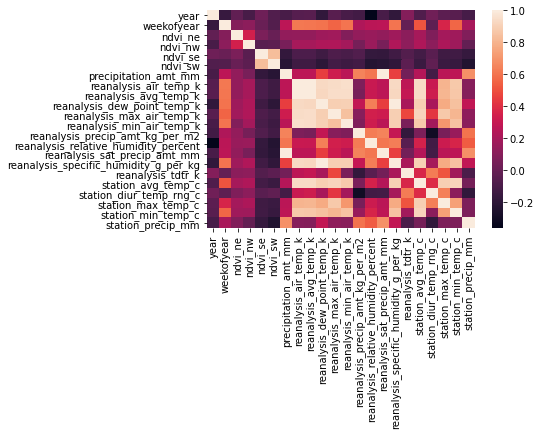

In [ ]:
mtx_corr = filter_data.corr()
sns.heatmap(mtx_corr, xticklabels=mtx_corr.columns, yticklabels=mtx_corr.columns, annot=False)

In [ ]:
repeated_pair=[]
for row in mtx_corr:
  i=0
  for feature in mtx_corr[row]:
    if (row != mtx_corr.columns[i]) & (feature >=0.95) & ([row, mtx_corr.columns[i]] not in repeated_pair):
      print('First variable: {var1}, Second variable: {var2}, Value: {val}'.format(var1=row, var2=mtx_corr.columns[i], val=feature))
      repeated_pair.append([mtx_corr.columns[i],row])
    i+=1



First variable: precipitation_amt_mm, Second variable: reanalysis_sat_precip_amt_mm, Value: 1.0
First variable: reanalysis_air_temp_k, Second variable: reanalysis_avg_temp_k, Value: 0.997679098612847
First variable: reanalysis_air_temp_k, Second variable: reanalysis_min_air_temp_k, Value: 0.9530881462741971
First variable: reanalysis_avg_temp_k, Second variable: reanalysis_min_air_temp_k, Value: 0.9513672725698957
First variable: reanalysis_dew_point_temp_k, Second variable: reanalysis_specific_humidity_g_per_kg, Value: 0.9989079658867076


We could see that there a bunch of features that have a strong correlation between them (we decided that a strong correlation would be a Pearson correlation coefficient more than 0.95). This pairs of features are the next ones:


*   ``precipitation_atm_mm`` and ``reanalysis_sat_precip_amt_mm`` with a correlation coefficient of 1.00
*   ``reanalysis_air_temp_k`` and ``reanalysis_avg_temp_k`` with a correlation coefficient of 0.9977
*   ``reanalysis_air_temp_k`` and ``reanalysis_min_air_temp_k`` with a correlation coefficient of 0.9530
*   ``reanalysis_avg_temp_k`` and ``reanalysis_min_air_temp_k`` with a correlation coefficient of 0.9514
*   ``reanalysis_dew_point_temp_k`` and ``reanalysis_specific_humidity_g_per_kg`` with a correlation coefficient of 0.9989



With a basic knowledge of the domain, we understand why that pairs of variables are strongly relationated.
* The first pair of variables are the total precipation each of them.
* The second pair represent the average air temperature and the mean air temperature, which it is the same.
* The third pair is also relationated but it hasn't the same meaning. One is the mean and the other is the minimum. Although, it has a very strong relation this three variables.
* The fourth pair is the same as the one before.
* At the fifth pair, we have investigated that the dew point temperature is influenced by the humidity. The dew point is the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100%.

![Dew-point-Temperature-for-22C-18C-and-16C-air-with-varying-humidity-Source-derived.png](https://www.researchgate.net/profile/Ken_Ruest/publication/44077697/figure/fig9/AS:668479581610007@1536389360856/Dew-point-Temperature-for-22C-18C-and-16C-air-with-varying-humidity-Source-derived.png)

---

We conclude that we could eliminate some features that are so redundant and not important. This features are ``reanalysis_sat_precip_amt_mm``, ``reanalysis_avg_temp_k`` and ``reanalysis_dew_point_temp_k``.

We eliminate this features from the normalized dataframe and we repeat the normalization of it.

In [ ]:
filter_data = filter_data.drop(['reanalysis_sat_precip_amt_mm', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k'], axis=1)
filter_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,1,1,-0.26830,-0.123700,0.223757,0.176543,0.00,297.648571,299.3,296.1,20.7,72.577143,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
712,1,2,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,299.3,296.1,20.7,72.577143,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,1,3,-0.18635,0.002600,0.282100,0.289900,36.07,297.800000,299.5,296.5,20.2,78.942857,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,1,4,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,300.2,295.7,1.1,78.264286,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,1,5,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,300.0,295.8,2.0,75.422857,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


In [ ]:
norm_data = scaler.fit_transform(filter_data)
norm_data

array([[0.        , 0.        , 0.15333741, ..., 0.13253012, 0.35897436,
        0.07518072],
       [0.        , 0.01923077, 0.37031068, ..., 0.13253012, 0.35897436,
        0.07518072],
       [0.        , 0.03846154, 0.24442839, ..., 0.19277108, 0.28205128,
        0.11421687],
       ...,
       [1.        , 0.26923077, 0.27905297, ..., 0.3253012 , 0.5       ,
        0.14795181],
       [1.        , 0.28846154, 0.45356528, ..., 0.3253012 , 0.5       ,
        0.0539759 ],
       [1.        , 0.30769231, 0.41043739, ..., 0.60240964, 0.70512821,
        0.00144578]])

### Principal Component Analysis


The technique of **Principal Component Analysis** consists of a dimension reduction that projects on *k* dimensions less than the ones we have, by maximizing the variance and with the lost of information.

---
We pass as argument to the PCA algorithm the normalized dataset.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca_estimation = pca.fit_transform(norm_data)
pca_estimation.shape

(225, 19)

Plotting the cumulative variance of each PCA component , we could decide how many components 

In [ ]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

We observe that the cumulative variance for having only two components is **not enough** and it is the same with more components, until it reaches the **even components**. The explained variance for seven components is **0.91**.

For this reason, we are going to **reduce the dimensionality** by *7 components*. This decision has advantages and disadvantages:

*   **Advantages:** the cumulative variance of having seven components allows us not having problem with lost of information and, by the way, obtaining better results.
*   **Disadvantages:** with six components, we have six variables which can't be represented graphically through a 2-dimensional or a 3-dimensional space.

To resolve this problem we are going to have two matrices, a 6-dimensional matrix ``studied_pca`` (and the most important) would be used for the operations needed for resolve our problem, and the last one would be a 3-variable matrix ``plot3d_pca``. This is due to the need of represent our data and this would be the best because 3D is good for a quick lookup and it doesn't lose as much information as a 2D representation.



In [ ]:
studied_pca = PCA (n_components = 7 ).fit_transform(norm_data)
plot3d_pca = PCA (n_components = 3 ).fit_transform(norm_data)

After that, we are going to plot our dataset represented in a 3-dimensional space.

In [ ]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(plot_pca, x = 0, y = 1, z = 2, size=filter_data['year'],
                    opacity=0.8, labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3', 'size': 'year', 'color': 'year', 'text': 'week_id'},
                    title=f'Total Explained Variance: {total_var:.2f}%',
                    text=filter_data.index, color=filter_data['year'])
fig.show()

This graph is grouped by year with colors and sizes.

## Outlier identification

The outlier detection is done by the DBSCAN algorithm. This technique is based on the theory that groups are defined by high-density areas. Low-density areas separate groups. The central points of a group have a neighborhood area for a given radius that has at least a minimum number of points, i.e. their neighborhood area exceeds a certain threshold.

### Setting parameters


1.   Computation of the distance matrix



In [ ]:
#Compute the similarity matrix
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(norm_data)

#Visualization
fig = px.imshow(matsim)
fig.show()